# 환경설정

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2

from pathlib import Path
import kagglehub

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchvision.models as models
from torchvision import models
from torchinfo import summary

from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.v2 as v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import copy

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from datetime import datetime


In [10]:
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

os.makedirs("pth", exist_ok=True)

PyTorch: 2.7.1
MPS available: True
mps


## 함수화

https://en.wikipedia.org/wiki/Early_stopping

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0, path=None):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path  # path를 멤버 변수로 저장

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.path is not None:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:
def train_model(model, loss_fn, optimizer, train_loader, val_loader, device, num_epochs=100, model_name="model", patience=5, delta=0.0, verbose=True):
    history = {'train_loss':[], 'val_loss': [], 'val_accuracy': [], 'val_f1': []}
    loss_name = loss_fn.__class__.__name__
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    best_model_path = f"./pth/{model_name}_{loss_name}_{ts}_earlystop_best.pth"
    early_stopping = EarlyStopping(patience=patience, verbose=verbose, delta=delta, path=best_model_path)


    for epoch in range(num_epochs):
        # training
        model.train()
        running_loss = 0.0
        for step, (X, y) in enumerate(train_loader, 1):
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = loss_fn(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if step % 50 == 0:
                print(f"[{model_name}] Epoch {epoch} step {step} train_loss = {loss.item():.6f}")

        avg_train_loss = running_loss / len(train_loader)
        # validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = loss_fn(preds, y)
                val_losses.append(loss.item())

                # accuracy 계산
                _, predicted = torch.max(preds, 1)
                val_correct += (predicted == y).sum().item()
                val_total += y.size(0)

                # F1 score 계산
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_accuracy = val_correct / val_total
        avg_val_loss = sum(val_losses) / len(val_losses)

        # F1 score 계산
        val_f1 = f1_score(all_labels, all_preds, average='weighted') #weighted: 클래스 비율 반영
                                                                    # micro: 전체 샘플에 대한 클래스별 정밀도와 재현율의 평균
        
        history['train_loss'].append(avg_train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)

        print(f"[{model_name}] Epoch {epoch} train_loss = {loss.item():.6f} val_loss={avg_val_loss:.6f} val_accuracy={val_accuracy:.6f} val_f1={val_f1:.6f}")

        # EarlyStopping 체크
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    # 학습 종료 후 best model 불러오기 (for 루프 밖)
    if early_stopping.path is not None:
        model.load_state_dict(torch.load(early_stopping.path))
    return history


## 데이터 불러오기

In [13]:
# KaggleHub 캐시를 현재 노트북 폴더 안에 .kagglehub_cache 로 고정
cache_dir = Path.cwd() / ".kagglehub_cache"
cache_dir.mkdir(parents=True, exist_ok=True)
os.environ["KAGGLEHUB_CACHE"] = str(cache_dir)

print(cache_dir)

# Download latest version
path = kagglehub.dataset_download("tongpython/cat-and-dog")

print("Path to dataset files:", path)


/Users/leeyoungho/develop/ai_study/kaggle/Cat_Dog/.kagglehub_cache
Path to dataset files: /Users/leeyoungho/develop/ai_study/kaggle/Cat_Dog/.kagglehub_cache/datasets/tongpython/cat-and-dog/versions/1


In [14]:
train_dir = os.path.join(path,"training_set/training_set")
test_dir = os.path.join(path, "test_set/test_set")

In [15]:
crop_h, crop_w = 224, 224 #ResNet18 기본 이미지 크기

# 데이터 전처리 정의
data_transforms = {
    'train': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.RandomCrop((200, 200)),          # 랜덤 크롭 (200x200)
        v2.RandomRotation(20),              # 랜덤 회전 (-20도 ~ 20도)
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'val': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'test': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ])
}


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## dataset 만들기

In [16]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [17]:
train_dataset_size = int(len(train_dataset)*0.8)
val_dataset_size = len(train_dataset) - train_dataset_size

train_dataset, val_dataset = random_split(train_dataset, [train_dataset_size, val_dataset_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 6404
Validation dataset size: 1601
Test dataset size: 2023


## dataloader 만들기

In [18]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델

## Pretrained 모델 사용

In [19]:
pretrained_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

In [20]:
summary(pretrained_model, (1, 3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

## features freeze, classifier 교체

### 1. 분류기 교체 (2클래스)

In [21]:
num_ftrs = pretrained_model.fc.in_features  # ImageNet용 ResNet18은 nn.Linear(512, 1000) 구조 -> num_ftrs = 512
pretrained_model.fc = nn.Linear(num_ftrs, 2)  # 클래스 수 = 2 (NORMAL, PNEUMONIA) # 마지막 FC layer를 512->2로 변경
pretrained_model = pretrained_model.to(device)


### 2. features freeze (가중치 고정)

In [36]:
for param in pretrained_model.parameters():
    param.requires_grad = False  # 모든 파라미터 freeze

for param in pretrained_model.layer4.parameters(): # 마지막 conv layer만 unfreeze
    param.requires_grad = True
for param in pretrained_model.fc.parameters():
    param.requires_grad = True   # 분류기만 학습

### 3. 손실함수, 옵티마이저 정의

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=1e-3)

### 4. train

In [38]:
history = train_model(
    pretrained_model,           # 모델
    criterion,                  # 손실 함수
    optimizer,                  # 옵티마이저
    train_loader,               # 학습 데이터로더
    val_loader,                 # 검증 데이터로더
    device,                     # 디바이스 (cpu/mps/cuda)
    num_epochs=10,              # 에폭 수 (원하는 만큼)
    model_name="resnet18_freeze" # 저장 파일명 접두사
)

[resnet18_freeze] Epoch 0 step 50 train_loss = 0.078852
[resnet18_freeze] Epoch 0 step 100 train_loss = 0.107206
[resnet18_freeze] Epoch 0 step 150 train_loss = 0.179481
[resnet18_freeze] Epoch 0 step 200 train_loss = 0.163821
[resnet18_freeze] Epoch 0 train_loss = 0.076827 val_loss=0.095168 val_accuracy=0.963148 val_f1=0.963148
↳ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250625_114659_best_epoch000_val0.095168.pth
[resnet18_freeze] Epoch 1 step 50 train_loss = 0.043905
[resnet18_freeze] Epoch 1 step 100 train_loss = 0.069545
[resnet18_freeze] Epoch 1 step 150 train_loss = 0.081837
[resnet18_freeze] Epoch 1 step 200 train_loss = 0.432158
[resnet18_freeze] Epoch 1 train_loss = 0.173643 val_loss=0.108327 val_accuracy=0.956902 val_f1=0.956885
[resnet18_freeze] Epoch 2 step 50 train_loss = 0.244330
[resnet18_freeze] Epoch 2 step 100 train_loss = 0.123434
[resnet18_freeze] Epoch 2 step 150 train_loss = 0.060556
[resnet18_freeze] Epoch 2 step 200 train_loss = 0.042796
[r

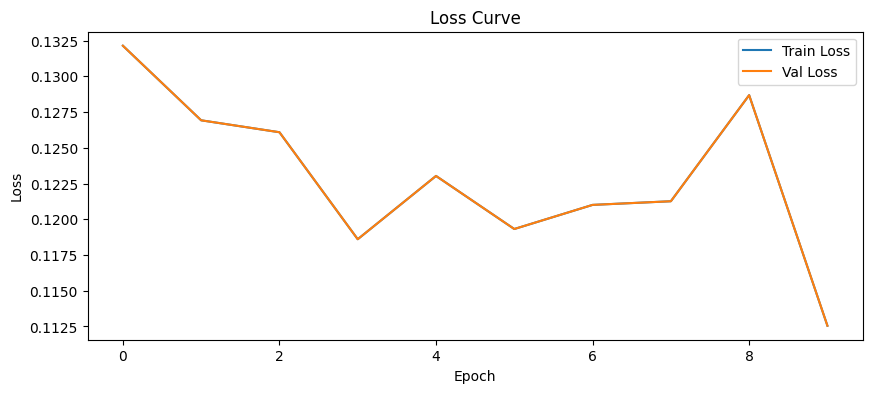

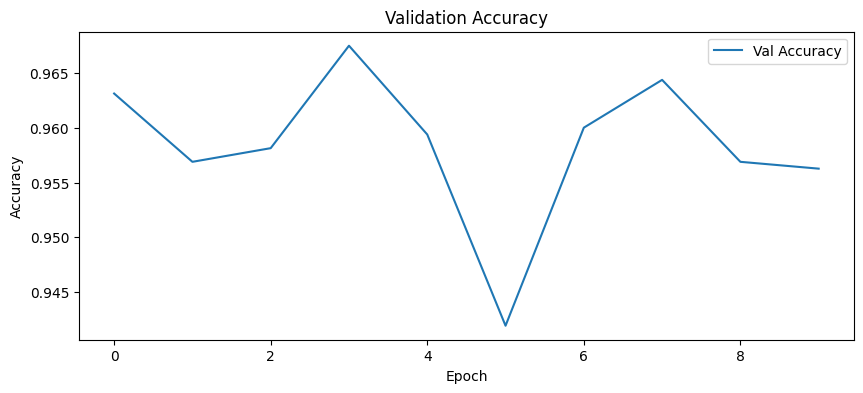

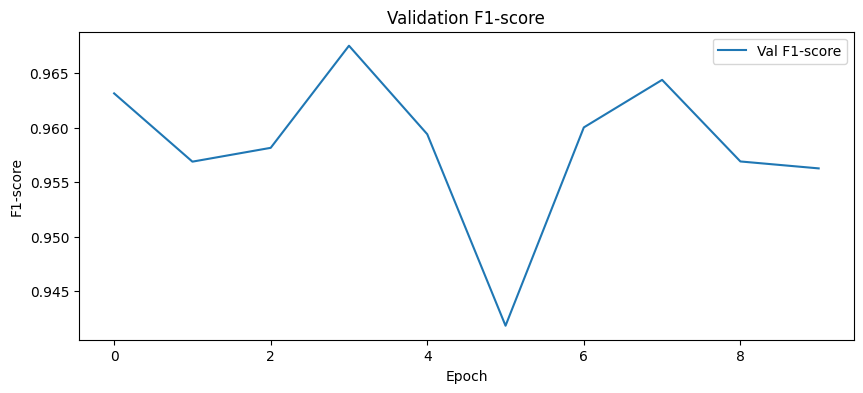

In [39]:
# 1. Loss 그래프
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()

### 모델 평가

#### best 모델 불러오기

In [27]:
pretrained_model_best_load = pretrained_model.to(device)
pretrained_model_best_load.load_state_dict(torch.load('pth/resnet18_freeze_CrossEntropyLoss_20250625_111756_best_epoch005_val0.084998.pth', map_location=device))
pretrained_model_best_load.to(device)
pretrained_model_best_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 테스트셋 평가

In [40]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = pretrained_model_best_load(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. 지표 계산
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.9718
Test F1-score: 0.9718
Confusion Matrix:
[[995  16]
 [ 41 971]]


### 분석결과

Test Accuracy: 0.9718 (97.18%)

Test F1-score: 0.9718 (97.18%)

-> F1-score와 Accuracy가 동일하다는 것은 precision과 recall이 균형 있게 잘 나왔다는 의미

Test dataset size: 2023 중

- 고양이 사진 : 1011개 중
    - 995개 고양이로 예측
    - 16개 개로 잘못 예측

- 개 사진 : 1012개 중
    - 971개 개로 예측
    - 41개 고양이로 잘못 예측

### 해석
- 과적합 없음 : 테스트셋에서도 높은 성능을 보임. overfitting 문제 거의 없음.
- 클래스 불균형 없음 : 오분류 수가 동일. 모델이 양쪽 모두 잘 학습함.
- 실제 오분류율 : 전체 2023개 샘플 중 60개만 오분류 -> 약 3% 미만의 오분류율

# Grad-CAM으로 시각화

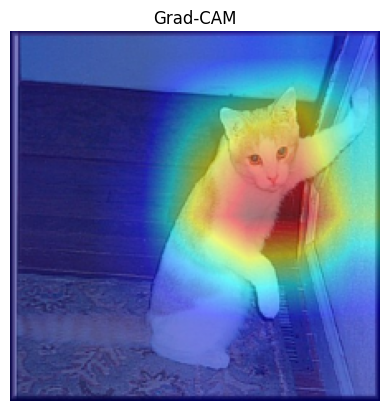

In [41]:
# 1. 모델 준비 (이미 학습된 모델 불러오기)
pretrained_model_best_load.eval()

# 2. Grad-CAM 객체 생성 (마지막 conv layer 지정)
target_layer = pretrained_model_best_load.layer4[-1]  # ResNet18의 마지막 conv block
cam = GradCAM(model=pretrained_model_best_load, target_layers=[target_layer])

# 3. 테스트 이미지 1장 불러오기
img_tensor, label = test_dataset[0]  # (C, H, W), torch.Tensor
input_tensor = img_tensor.unsqueeze(0).to(device)  # 배치 차원 추가

# 4. CAM 생성
grayscale_cam = cam(input_tensor=input_tensor)[0]  # (H, W), numpy

# 5. 원본 이미지로 변환
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # 0~1 정규화

# 6. CAM 시각화
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

### train_finetuning

In [22]:
pretrained_finetune_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

In [23]:
num_ftrs = pretrained_finetune_model.fc.in_features  # ImageNet용 ResNet18은 nn.Linear(512, 1000) 구조 -> num_ftrs = 512
pretrained_finetune_model.fc = nn.Linear(num_ftrs, 2)  # 클래스 수 = 2 (NORMAL, PNEUMONIA) # 마지막 FC layer를 512->2로 변경
pretrained_finetune_model = pretrained_finetune_model.to(device)


In [24]:
for param in pretrained_finetune_model.parameters():
    param.requires_grad = False  # 모든 파라미터 freeze

for param in pretrained_finetune_model.layer4.parameters(): # 마지막 conv layer만 unfreeze
    param.requires_grad = True
for param in pretrained_finetune_model.fc.parameters():
    param.requires_grad = True   # 분류기만 학습

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_finetune_model.fc.parameters(), lr=1e-3)

In [32]:
history = train_model(
    pretrained_finetune_model,           # 모델
    criterion,                  # 손실 함수
    optimizer,                  # 옵티마이저
    train_loader,               # 학습 데이터로더
    val_loader,                 # 검증 데이터로더
    device,                     # 디바이스 (cpu/mps/cuda)
    num_epochs=100,              # 에폭 수 (원하는 만큼)
    model_name="resnet18_finetune",
    patience=12,
    delta=0.0005,
    verbose=True
)

[resnet18_finetune] Epoch 0 step 50 train_loss = 0.164552
[resnet18_finetune] Epoch 0 step 100 train_loss = 0.095527
[resnet18_finetune] Epoch 0 step 150 train_loss = 0.036691
[resnet18_finetune] Epoch 0 step 200 train_loss = 0.086513
[resnet18_finetune] Epoch 0 train_loss = 0.000087 val_loss=0.077342 val_accuracy=0.969394 val_f1=0.969392
[resnet18_finetune] Epoch 1 step 50 train_loss = 0.171771
[resnet18_finetune] Epoch 1 step 100 train_loss = 0.296798
[resnet18_finetune] Epoch 1 step 150 train_loss = 0.145712
[resnet18_finetune] Epoch 1 step 200 train_loss = 0.177648
[resnet18_finetune] Epoch 1 train_loss = 0.000145 val_loss=0.080906 val_accuracy=0.968770 val_f1=0.968764
EarlyStopping counter: 1 out of 12
[resnet18_finetune] Epoch 2 step 50 train_loss = 0.118248
[resnet18_finetune] Epoch 2 step 100 train_loss = 0.275251
[resnet18_finetune] Epoch 2 step 150 train_loss = 0.037850
[resnet18_finetune] Epoch 2 step 200 train_loss = 0.253383
[resnet18_finetune] Epoch 2 train_loss = 0.00287

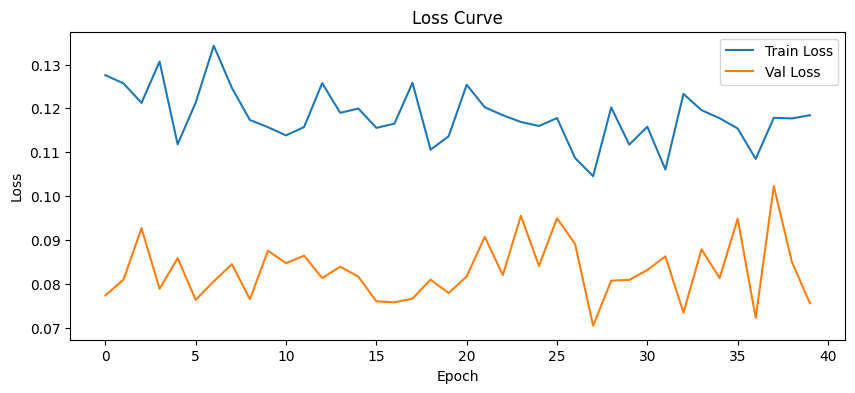

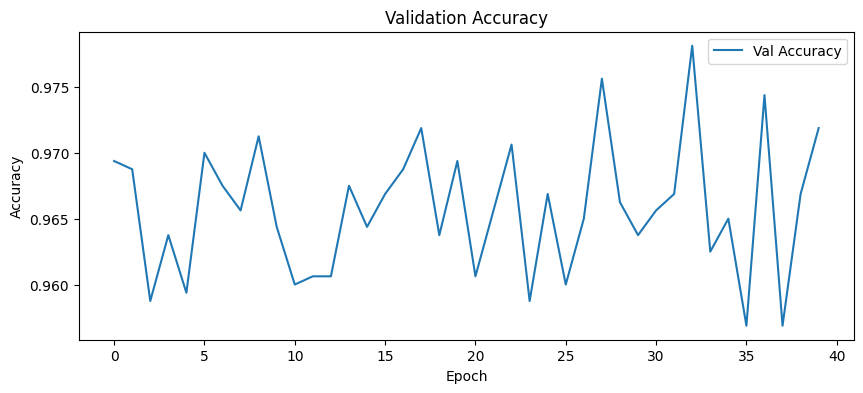

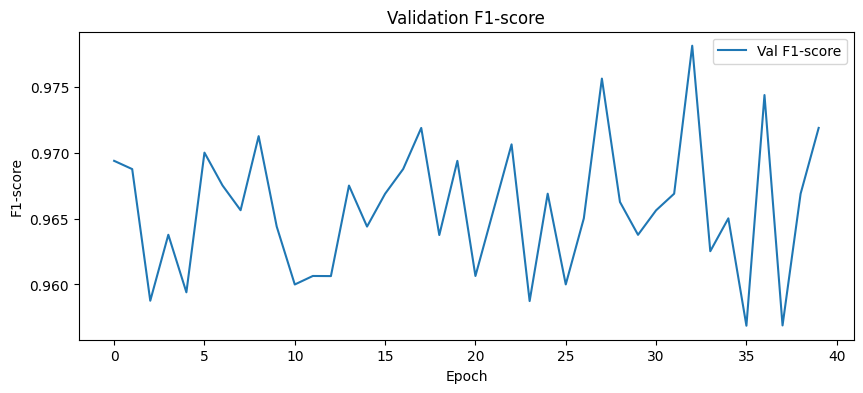

In [33]:
# 1. Loss 그래프
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()

In [34]:
pretrained_model_finetunebest_load = pretrained_finetune_model.to(device)
pretrained_model_finetunebest_load.load_state_dict(torch.load('pth/resnet18_finetune_CrossEntropyLoss_20250625_145119_earlystop_best.pth', map_location=device))
pretrained_model_finetunebest_load.to(device)
pretrained_model_finetunebest_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = pretrained_model_finetunebest_load(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. 지표 계산
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.9723
Test F1-score: 0.9723
Confusion Matrix:
[[976  35]
 [ 21 991]]


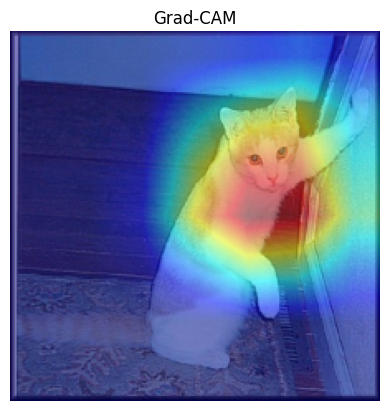

In [36]:
# 1. 모델 준비 (이미 학습된 모델 불러오기)
pretrained_model_finetunebest_load.eval()

# 2. Grad-CAM 객체 생성 (마지막 conv layer 지정)
target_layer = pretrained_model_finetunebest_load.layer4[-1]  # ResNet18의 마지막 conv block
cam = GradCAM(model=pretrained_model_finetunebest_load, target_layers=[target_layer])

# 3. 테스트 이미지 1장 불러오기
img_tensor, label = test_dataset[0]  # (C, H, W), torch.Tensor
input_tensor = img_tensor.unsqueeze(0).to(device)  # 배치 차원 추가

# 4. CAM 생성
grayscale_cam = cam(input_tensor=input_tensor)[0]  # (H, W), numpy

# 5. 원본 이미지로 변환
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # 0~1 정규화

# 6. CAM 시각화
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()